In [29]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig,TFBertModel,CamembertTokenizer, TFCamembertForSequenceClassification

tf.random.set_seed(42)
np.random.seed(42)

In [30]:
df = pd.read_excel(io="./data/historique_interventions_IA.xlsx", sheet_name="liste inter CATEGORISEES LIGHT")
df.columns = [title.lower().replace(" ", "_") for title in df.columns]
df.columns

Index(['description', 'activity_text', 's-ens', 'cat'], dtype='object')

In [31]:
df['s-ens_cleaned'] = df['s-ens'].str.lower()
df = df[['description','s-ens_cleaned']]
df.dropna(inplace=True)
df.columns = ['description', "labels"]

In [32]:
count = df.groupby('labels').count().reset_index()

nb_min_to_keep = 10 

result = count[count['description'] > nb_min_to_keep]
result['labels']
nb_targets = result['labels'].nunique()
display(count)

,labels,description
0,autom,13
1,barre ionisante,3
2,bi,5
3,bol bouchon,25
4,cellules,61
5,climet,6
6,communication,18
7,convoyeur entrée,9
8,convoyeur principal,30
9,courroie,1


In [33]:
list_label_to_keep = result['labels'].unique()

In [34]:
df = df[df['labels'].isin(list_label_to_keep)]

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
# Création de l'encodeur
le = LabelEncoder()
nb_targets = df['labels'].nunique()
# Entraînement de l'encodeur et transformation des labels
df['labels_encoded'] = le.fit_transform(df['labels'])

y = df['labels_encoded']


filename = './save_model/labelencoder.pkl'
pickle.dump(le, open(filename, 'wb'))


X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(np.array(df['description']), y,
                                                   test_size=0.2,
                                                   random_state = 0,
                                                   stratify=y,
                                                   shuffle=True)

In [113]:
tokenizer = CamembertTokenizer("./save_model/tokenizer_model.model")

model = TFCamembertModel.from_pretrained("jplu/tf-camembert-base",num_labels=nb_targets)
LONGUEUR_MAX_COMMENTAIRE = df.description.str.len().max()
output_tokenizer_entrainement = tokenizer(list(X_train_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
output_tokenizer_tests = tokenizer(list(X_test_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Some layers from the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [37]:
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32')
sortie_camemBERT = model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_camemBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_camemBERT,trainable=False)
model_camemBERT.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model_1 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 membertModel)               ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [38]:
output = Dense(nb_targets, activation='softmax')(sortie_camemBERT[1])  # Use pooled representation
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs=output)
model.layers[2].trainable = False  # Disable training of CamemBERT

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-2), metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model_1 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 membertModel)               ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [39]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=10, verbose=1, batch_size = 2,callbacks=[early], workers=-1, 
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test_nlp))

Epoch 1/10
208/208 [==============================] - 43s 173ms/step - loss: 2.5402 - accuracy: 0.2067 - val_loss: 2.6013 - val_accuracy: 0.2095
Epoch 2/10
208/208 [==============================] - 31s 148ms/step - loss: 2.2285 - accuracy: 0.3173 - val_loss: 2.3557 - val_accuracy: 0.1333
Epoch 3/10
208/208 [==============================] - 31s 148ms/step - loss: 1.9954 - accuracy: 0.3462 - val_loss: 2.1693 - val_accuracy: 0.3619
Epoch 4/10
208/208 [==============================] - 31s 151ms/step - loss: 1.9212 - accuracy: 0.3942 - val_loss: 2.0504 - val_accuracy: 0.3143
Epoch 5/10
208/208 [==============================] - 31s 150ms/step - loss: 1.7140 - accuracy: 0.4447 - val_loss: 1.9385 - val_accuracy: 0.4762
Epoch 6/10
208/208 [==============================] - 31s 149ms/step - loss: 1.6560 - accuracy: 0.5216 - val_loss: 1.7659 - val_accuracy: 0.5143
Epoch 7/10
208/208 [==============================] - 31s 149ms/step - loss: 1.5709 - accuracy: 0.5120 - val_loss: 1.8299 - val_ac

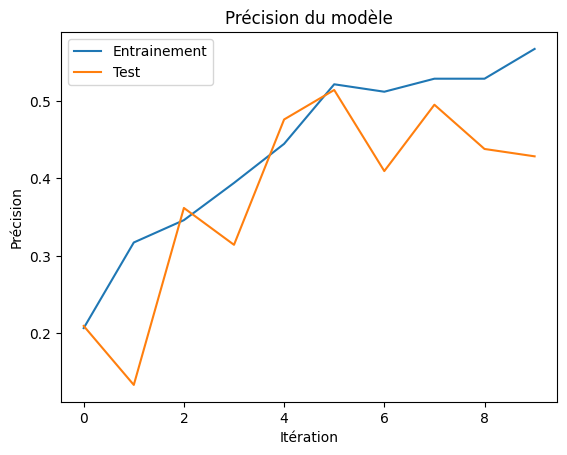

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

In [41]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model_1 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 membertModel)               ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

Total params: 110632718 (422.03 MB)
Trainable params: 110632718 (422.03 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [42]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=20, verbose=1, batch_size = 8,callbacks=[early], workers=-1, use_multiprocessing=False,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test_nlp))

Epoch 1/20
52/52 [==============================] - 127s 2s/step - loss: 2.0816 - accuracy: 0.4760 - val_loss: 1.9417 - val_accuracy: 0.5333
Epoch 2/20
52/52 [==============================] - 104s 2s/step - loss: 0.6478 - accuracy: 0.8197 - val_loss: 1.5311 - val_accuracy: 0.6571
Epoch 3/20
52/52 [==============================] - 98s 2s/step - loss: 0.4005 - accuracy: 0.8942 - val_loss: 1.4666 - val_accuracy: 0.7238
Epoch 4/20
52/52 [==============================] - 111s 2s/step - loss: 0.1960 - accuracy: 0.9447 - val_loss: 1.4818 - val_accuracy: 0.6952
Epoch 5/20
52/52 [==============================] - 102s 2s/step - loss: 0.1424 - accuracy: 0.9639 - val_loss: 1.7413 - val_accuracy: 0.7048
Epoch 6/20
52/52 [==============================] - 94s 2s/step - loss: 0.1024 - accuracy: 0.9712 - val_loss: 1.8753 - val_accuracy: 0.7048
Epoch 7/20
52/52 [==============================] - 100s 2s/step - loss: 0.0529 - accuracy: 0.9856 - val_loss: 1.8502 - val_accuracy: 0.7143
Epoch 8/20
52/5

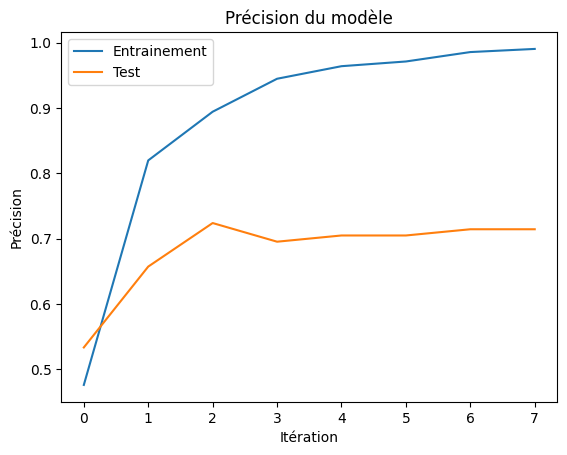

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

In [108]:
with open("./save_model/labelencoder.pkl","rb") as file:
    le =pickle.load(file)

In [109]:
def encode_texts(texts, tokenizer, max_seq_length):
    input_ids = []

    encoded = tokenizer(texts,max_length=max_seq_length, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
    input_ids.append([encoded["input_ids"],encoded["attention_mask"]])
    return input_ids

def prediction(model, max_seq_length, *args) :
    texts = list(*args)
    to_test = encode_texts(texts=texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
    proba = model.predict(*to_test)
    indexes = np.argmax(proba, axis=1)
    return le.inverse_transform(indexes)

In [110]:
text_test = 'Défaut de com HMI IPC.'
test1 = 'Ecran IPC'
test2 = 'defaut communication sur hmi ipc'
prediction(model, LONGUEUR_MAX_COMMENTAIRE,[text_test,test1,test2])

1/1 [==============================] - 0s 186ms/step


array(['hmi', 'hmi', 'communication'], dtype=object)

In [57]:
le.transform(prediction(model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp))

4/4 [==============================] - 4s 917ms/step


array([ 6,  7, 11,  7,  7,  5, 13,  5,  7,  6,  4,  4,  6,  6,  6, 13,  6,
       12,  5,  4,  6,  4,  5,  2,  4,  5,  5,  4,  5,  7,  6,  2,  6,  5,
        5,  6,  8,  6,  9,  6,  4,  6, 11,  6,  5,  9,  8,  2,  1, 10,  8,
        4,  5,  7,  7,  7,  3,  7,  6,  8,  6, 13, 13,  1,  5,  4,  7,  8,
        7,  6,  6, 13,  6,  5,  5,  3,  5,  7,  4,  2,  2,  7,  1,  9,  4,
       13,  1,  4,  4,  5,  2,  8,  5,  4, 11, 13,  5,  6,  6, 13,  4,  4,
        2,  7,  0])

In [62]:
y_test_nlp.to_numpy()

array([ 6,  7, 11,  7,  7,  5, 13,  7,  7,  6,  4,  4,  5,  6,  6, 13,  6,
        0,  5,  0,  6,  7,  5,  8,  5,  5,  5,  8,  5,  2,  6,  2,  6,  5,
        5,  3,  8,  6,  9,  6,  6,  6, 11,  6,  5,  9,  2,  2,  1, 10,  8,
        4,  5,  7,  7,  7,  3,  2,  6, 10,  6,  9, 12,  1,  5,  4,  7,  2,
        7,  6,  6,  2,  6,  5,  3,  3,  5,  7,  4,  2,  2,  7,  1, 13,  4,
        9,  1,  2,  8,  7,  6,  8,  5, 12, 11, 13,  5,  6,  6, 13,  5,  1,
        2,  2,  0])

In [74]:
metric = tf.keras.metrics.F1Score(threshold=0.5)

metric.update_state(y_test_nlp.to_numpy().reshape(1,-1), le.transform(prediction(model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp)).reshape(1,-1))
result = metric.result()
result.numpy()


4/4 [==============================] - 4s 924ms/step


array([1.7142857, 1.75     , 1.8333334, 1.75     , 1.75     , 1.6666666,
       1.8571428, 1.75     , 1.75     , 1.7142857, 1.6      , 1.6      ,
       1.6666666, 1.7142857, 1.7142857, 1.8571428, 1.7142857, 0.       ,
       1.6666666, 0.       , 1.7142857, 1.75     , 1.6666666, 1.7777778,
       1.6666666, 1.6666666, 1.6666666, 1.7777778, 1.6666666, 1.3333334,
       1.7142857, 1.3333334, 1.7142857, 1.6666666, 1.6666666, 1.5      ,
       1.7777778, 1.7142857, 1.8      , 1.7142857, 1.7142857, 1.7142857,
       1.8333334, 1.7142857, 1.6666666, 1.8      , 1.3333334, 1.3333334,
       1.       , 1.8181819, 1.7777778, 1.6      , 1.6666666, 1.75     ,
       1.75     , 1.75     , 1.5      , 1.3333334, 1.7142857, 1.8181819,
       1.7142857, 1.8      , 1.8461539, 1.       , 1.6666666, 1.6      ,
       1.75     , 1.3333334, 1.75     , 1.7142857, 1.7142857, 1.3333334,
       1.7142857, 1.6666666, 1.5      , 1.5      , 1.6666666, 1.75     ,
       1.6      , 1.3333334, 1.3333334, 1.75     , 

In [104]:
y_true

array([[ 6,  7, 11,  7,  7,  5, 13,  7,  7,  6,  4,  4,  5,  6,  6, 13,
         6,  0,  5,  0,  6,  7,  5,  8,  5,  5,  5,  8,  5,  2,  6,  2,
         6,  5,  5,  3,  8,  6,  9,  6,  6,  6, 11,  6,  5,  9,  2,  2,
         1, 10,  8,  4,  5,  7,  7,  7,  3,  2,  6, 10,  6,  9, 12,  1,
         5,  4,  7,  2,  7,  6,  6,  2,  6,  5,  3,  3,  5,  7,  4,  2,
         2,  7,  1, 13,  4,  9,  1,  2,  8,  7,  6,  8,  5, 12, 11, 13,
         5,  6,  6, 13,  5,  1,  2,  2,  0]])

In [103]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

# Assuming you have trained your model and obtained predictions
# Replace this with your actual test/validation data and predictions
y_true = y_test_nlp.to_numpy().reshape(1,-1)
y_pred = prediction(model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp).reshape(1,-1)


# Flatten the multi-label data for f1_score calculation
f1 = f1_score(y_true.ravel(), y_pred.ravel(), average='macro')

print("Macro F1 Score (Multi-label):", f1)


4/4 [==============================] - 4s 901ms/step


ValueError: Mix of label input types (string and number)

In [93]:
from sklearn.metrics import classification_report

y_true_flat = y_true
y_pred_flat = y_pred

# Use classification_report
report = classification_report(y_true_flat, y_pred_flat)
print(report)

ValueError: Found input variables with inconsistent numbers of samples: [1, 105]

In [48]:
model_path = "./save_model/"
date = datetime.now()
model.save(model_path+f"nlp_{nb_targets}_nb_class_{date}.h5")

/home/apprenant/miniconda3/envs/nlp_fail/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [111]:
custom_objects = {'TFCamembertModel': TFCamembertModel}
model_path =  "save_model/nlp_14_nb_class_2023-11-21 15:14:07.250352.h5"
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model_3 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 membertModel)               ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [114]:
test1 = 'Remplacemetn ecran IPC'
test2 = 'Ecran IPC figé'
test3 = "Perte de COM"
prediction(loaded_model, LONGUEUR_MAX_COMMENTAIRE,[test1,test2,test3])

1/1 [==============================] - 0s 222ms/step


array(['ipc', 'hmi', 'communication'], dtype=object)